# Object Oriented ML

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/logo.png" width=150>

In this notebook, we will learn how to properly create and use classes & functions to solve ML tasks with PyTorch. We will be following this implementation structure in subsequent notebooks.





# Overview

Here is the overview of the different classes and the functionality they will have.

*   **Vocabulary**: dictionaries to convert between raw inputs and numerical form. Usually useful for NLP tasks to build and store vocabulary dictionaries.
*   **Vectorizer**: instances of the vocabulary class for inputs and outputs and vectorizes the data for the model.
*   **Dataset**: vectorizers to process the data and data splits.
*   **Model**: PyTorch model to process inputs and return predictions.
* **Trainer**: training operations using the dataset, vectorizer and model.
* **Inference**: inference operations for new data

Credit for the code structure in the implementations below and in subsequent lessons goes to these [contributors](https://github.com/joosthub/PyTorchNLPBook/graphs/contributors).

# Configuration

We will be using these configurations throughout the notebook for our task of predicting nationality given a surname.

In [0]:
config = {
  "seed": 1234,
  "cuda": True,
  "data_url": "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/surnames.csv",
  "data_file": "datasets/surnames.csv",
  "shuffle": True,
  "train_size": 0.7,
  "val_size": 0.15,
  "test_size": 0.15,
  "vectorizer_file": "vectorizer.json",
  "model_file": "model.pth",
  "save_dir": "experiments",
  "num_epochs": 20,
  "early_stopping_criteria": 5,
  "learning_rate": 1e-3,
  "batch_size": 128,
  "fc": {
    "hidden_dim": 300,
    "dropout_p": 0.1
  }
}

# Set up

We're going to get set up for our task by setting reproducability seeds with NumPy and PyTorch. We will also create a unique directory to store our configurations, model, etc.

In [2]:
# Load PyTorch library
!pip3 install torch

In [0]:
import os
import json
import numpy as np
import time
import torch
import uuid

### Components

In [0]:
def set_seeds(seed, cuda):
    """ Set Numpy and PyTorch seeds.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
    print ("==> 🌱 Set NumPy and PyTorch seeds.")

In [0]:
def generate_unique_id():
    """Generate a unique uuid
    preceded by a epochtime.
    """
    timestamp = int(time.time())
    unique_id = "{}_{}".format(timestamp, uuid.uuid1())
    print ("==> 🔑 Generated unique id: {0}".format(unique_id))
    return unique_id

In [0]:
def create_dirs(dirpath):
    """Creating directories.
    """
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        print ("==> 📂 Created {0}".format(dirpath))

In [0]:
def check_cuda(cuda):
    """Check to see if GPU is available.
    """
    if not torch.cuda.is_available():
        cuda = False
    device = torch.device("cuda" if cuda else "cpu")
    print ("==> 💻 Device: {0}".format(device))
    return device

### Operations

In [8]:
# Set seeds for reproducability
set_seeds(seed=config["seed"], cuda=config["cuda"])

==> 🌱 Set NumPy and PyTorch seeds.


In [9]:
# Generate unique experiment ID
config["experiment_id"] = generate_unique_id()

==> 🔑 Generated unique id: 1567929797_1d5e996e-d20f-11e9-bb1d-0242ac1c0002


In [10]:
# Create experiment directory
config["save_dir"] = os.path.join(config["save_dir"], config["experiment_id"])
create_dirs(dirpath=config["save_dir"])

==> 📂 Created experiments/1567929797_1d5e996e-d20f-11e9-bb1d-0242ac1c0002


In [11]:
# Expand file paths to store components later
config["vectorizer_file"] = os.path.join(config["save_dir"], config["vectorizer_file"])
config["model_file"] = os.path.join(config["save_dir"], config["model_file"])
print ("Expanded filepaths: ")
print ("{}".format(config["vectorizer_file"]))
print ("{}".format(config["model_file"]))

Expanded filepaths: 
experiments/1567929797_1d5e996e-d20f-11e9-bb1d-0242ac1c0002/vectorizer.json
experiments/1567929797_1d5e996e-d20f-11e9-bb1d-0242ac1c0002/model.pth


In [0]:
# Save config
config_fp = os.path.join(config["save_dir"], "config.json")
with open(config_fp, "w") as fp:
    json.dump(config, fp)

In [13]:
# Check CUDA
config["device"] = check_cuda(cuda=config["cuda"])

==> 💻 Device: cuda


# Load data

Get the data from the GitHub URL and then load it into a Pandas DataFrame.

In [0]:
import pandas as pd
import urllib

### Components

In [0]:
def get_data(data_url, data_file):
    """Get data from GitHub to notebook's
    local drive.
    """
    # Create dataset directory
    dirpath = os.path.dirname(data_file)
    create_dirs(dirpath)
    
    # Fetch data
    response = urllib.request.urlopen(config["data_url"])
    html = response.read()
    with open(config["data_file"], 'wb') as fp:
        fp.write(html)
    print ("==> 🐙 Downloading data from GitHub to {0}".format(data_file))

In [0]:
def load_data(data_file):
    """Load data from CSV to Pandas DataFrame.
    """
    # Load into DataFrame
    df = pd.read_csv(data_file, header=0)
    print ("==> 🍣 Raw data:")
    print (df.head())
    return df

### Operations

In [17]:
# Get data from GitHub
get_data(data_url=config["data_url"], data_file=config["data_file"])

==> 📂 Created datasets
==> 🐙 Downloading data from GitHub to datasets/surnames.csv


In [18]:
# Load data into Pandas DataFrame
df = load_data(data_file=config["data_file"])

==> 🍣 Raw data:
    surname nationality
0  Woodford     English
1      Coté      French
2      Kore     English
3     Koury      Arabic
4    Lebzak     Russian


# Split data

Split the data into train, validation and test sets where each split has similar class distributions. 

In [0]:
import collections

### Components

In [0]:
def split_data(df, shuffle, train_size, val_size, test_size):
    """Split the data into train/val/test splits.
    """
    # Split by category
    by_category = collections.defaultdict(list)
    for _, row in df.iterrows():
        by_category[row.nationality].append(row.to_dict())
    print ("\n==> 🛍️ Categories:")
    for category in by_category:
        print ("{0}: {1}".format(category, len(by_category[category])))

    # Create split data
    final_list = []
    for _, item_list in sorted(by_category.items()):
        if shuffle:
            np.random.shuffle(item_list)
        n = len(item_list)
        n_train = int(train_size*n)
        n_val = int(val_size*n)
        n_test = int(test_size*n)

      # Give data point a split attribute
        for item in item_list[:n_train]:
            item['split'] = 'train'
        for item in item_list[n_train:n_train+n_val]:
            item['split'] = 'val'
        for item in item_list[n_train+n_val:]:
            item['split'] = 'test'

        # Add to final list
        final_list.extend(item_list)

    # df with split datasets
    split_df = pd.DataFrame(final_list)
    print ("\n==> 🖖 Splits:")
    print (split_df["split"].value_counts())

    return split_df

### Operations

In [21]:
# Split data
split_df = split_data(
    df=df, shuffle=config["shuffle"],
    train_size=config["train_size"],
    val_size=config["val_size"],
    test_size=config["test_size"])


==> 🛍️ Categories:
English: 2972
French: 229
Arabic: 1603
Russian: 2373
Japanese: 775
Chinese: 220
Italian: 600
Czech: 414
Irish: 183
German: 576
Greek: 156
Spanish: 258
Polish: 120
Dutch: 236
Vietnamese: 58
Korean: 77
Portuguese: 55
Scottish: 75

==> 🖖 Splits:
train    7680
test     1660
val      1640
Name: split, dtype: int64


# Preprocessing

Preprocess the data in the DataFrame.

In [0]:
import re

### Components

In [0]:
def preprocess_text(text):
    """Basic text preprocessing.
    """
    text = ' '.join(word.lower() for word in text.split(" "))
    text = text.replace('\n', ' ')
    text = re.sub(r"[^a-zA-Z.!?_]+", r" ", text)
    text = text.strip()
    return text

In [0]:
def preprocess_data(df):
    """ Preprocess the DataFrame.
    """
    df.surname = df.surname.apply(preprocess_text)
    print ("\n==> 🚿 Preprocessing:")
    print (df.head())
    return df

### Operations

In [25]:
# Preprocessing
preprocessed_df = preprocess_data(split_df)


==> 🚿 Preprocessing:
  nationality  split  surname
0      Arabic  train  bishara
1      Arabic  train    nahas
2      Arabic  train   ghanem
3      Arabic  train  tannous
4      Arabic  train  mikhail


# Vocabulary

Create vocabularies for the surnames and nationality classes.

### Components

In [0]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):

        # Token to index
        if token_to_idx is None:
            token_to_idx = {}
        self.token_to_idx = token_to_idx

        # Index to token
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}
        
        # Add unknown token
        self.add_unk = add_unk
        self.unk_token = unk_token
        if self.add_unk:
            self.unk_index = self.add_token(self.unk_token)

    def to_serializable(self):
        return {'token_to_idx': self.token_to_idx,
                'add_unk': self.add_unk, 'unk_token': self.unk_token}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index

    def add_tokens(self, tokens):
        return [self.add_token[token] for token in tokens]

    def lookup_token(self, token):
        if self.add_unk:
            index = self.token_to_idx.get(token, self.unk_index)
        else:
            index =  self.token_to_idx[token]
        return index

    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self.idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self.token_to_idx)

### Operations

In [27]:
# Vocabulary instance
nationality_vocab = Vocabulary(add_unk=False)
for index, row in preprocessed_df.iterrows():
    nationality_vocab.add_token(row.nationality)
print (nationality_vocab) # __str__
print (len(nationality_vocab)) # __len__
index = nationality_vocab.lookup_token("English")
print (index)
print (nationality_vocab.lookup_index(index))

<Vocabulary(size=18)>
18
4
English


# Vectorizer

Vectorizes our data into numerical form using the vocabularies.

### Components

In [0]:
class SurnameVectorizer(object):
    def __init__(self, surname_vocab, nationality_vocab):
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname):
        one_hot = np.zeros(len(self.surname_vocab), dtype=np.float32)
        for token in surname:
            one_hot[self.surname_vocab.lookup_token(token)] = 1
        return one_hot

    def unvectorize(self, one_hot):
        surname = [vectorizer.surname_vocab.lookup_index(index) \
            for index in np.where(one_hot==1)[0]]
        return surname
        
    @classmethod
    def from_dataframe(cls, df):
        surname_vocab = Vocabulary(add_unk=True)
        nationality_vocab = Vocabulary(add_unk=False)

        # Create vocabularies
        for index, row in df.iterrows():
            for letter in row.surname: # char-level tokenization
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)
        return cls(surname_vocab, nationality_vocab)

    @classmethod
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
        nationality_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(surname_vocab, nationality_vocab)

    def to_serializable(self):
        return {'surname_vocab': self.surname_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable()}

### Operations

In [29]:
# Vectorizer instance
vectorizer = SurnameVectorizer.from_dataframe(preprocessed_df)
print (vectorizer.surname_vocab)
print (vectorizer.nationality_vocab)
one_hot = vectorizer.vectorize(preprocess_text("goku"))
print (one_hot)
print (vectorizer.unvectorize(one_hot))

<Vocabulary(size=28)>
<Vocabulary(size=18)>
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
['g', 'o', 'u', 'k']


**Note**: When we vectorize our input with bagged one hot encoded format, we lose all the structure in our name. This is a major disadvantage of representing our text in bagged one-hot encoded form but we will explore more semantic structure preserving encoding methods later.

# Dataset

The Dataset will create vectorized data from the preprocessed data.

In [0]:
import random
from torch.utils.data import Dataset, DataLoader

### Components

In [0]:
class SurnameDataset(Dataset):
    def __init__(self, df, vectorizer, infer=False):
        self.df = df
        self.vectorizer = vectorizer
        
        # Data splits
        if not infer:
            self.train_df = self.df[self.df.split=='train']
            self.train_size = len(self.train_df)
            self.val_df = self.df[self.df.split=='val']
            self.val_size = len(self.val_df)
            self.test_df = self.df[self.df.split=='test']
            self.test_size = len(self.test_df)
            self.lookup_dict = {'train': (self.train_df, self.train_size), 
                                'val': (self.val_df, self.val_size),
                                'test': (self.test_df, self.test_size)}
            self.set_split('train')

            # Class weights (for imbalances)
            class_counts = df.nationality.value_counts().to_dict()
            def sort_key(item):
                return self.vectorizer.nationality_vocab.lookup_token(item[0])
            sorted_counts = sorted(class_counts.items(), key=sort_key)
            frequencies = [count for _, count in sorted_counts]
            self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        elif infer:
            self.infer_df = self.df[self.df.split=="infer"]
            self.infer_size = len(self.infer_df)
            self.lookup_dict = {'infer': (self.infer_df, self.infer_size)}
            self.set_split('infer')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, df):
        train_df = df[df.split=='train']
        return cls(df, SurnameVectorizer.from_dataframe(train_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, df, vectorizer_filepath):
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(df, vectorizer)

    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self.vectorizer.to_serializable(), fp)

    def set_split(self, split="train"):
        self.target_split = split
        self.target_df, self.target_size = self.lookup_dict[split]

    def __str__(self):
        return "<Dataset(split={0}, size={1})>".format(
            self.target_split, self.target_size)

    def __len__(self):
        return self.target_size

    def __getitem__(self, index):
        row = self.target_df.iloc[index]
        surname_vector = self.vectorizer.vectorize(row.surname)
        nationality_index = self.vectorizer.nationality_vocab.lookup_token(row.nationality)
        return {'surname': surname_vector, 'nationality': nationality_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def generate_batches(self, batch_size, shuffle=True, drop_last=False, device="cpu"):
        dataloader = DataLoader(dataset=self, batch_size=batch_size, 
                                shuffle=shuffle, drop_last=drop_last)
        for data_dict in dataloader:
            out_data_dict = {}
            for name, tensor in data_dict.items():
                out_data_dict[name] = data_dict[name].to(device)
            yield out_data_dict

In [0]:
def sample(dataset):
    """Some sanity checks on the dataset.
    """
    sample_idx = random.randint(0,len(dataset))
    sample = dataset[sample_idx]
    print ("\n==> 🔢 Dataset:")
    print ("Random sample: {0}".format(sample))
    print ("Unvectorized surname: {0}".format(
        dataset.vectorizer.unvectorize(sample['surname'])))
    print ("Unvectorized nationality: {0}".format(
        dataset.vectorizer.nationality_vocab.lookup_index(sample['nationality'])))

### Operations

In [33]:
# Load dataset and vectorizer
dataset = SurnameDataset.load_dataset_and_make_vectorizer(preprocessed_df)
dataset.save_vectorizer(config["vectorizer_file"])
vectorizer = dataset.vectorizer
print (dataset.class_weights)

tensor([0.0006, 0.0045, 0.0024, 0.0042, 0.0003, 0.0044, 0.0017, 0.0064, 0.0055,
        0.0017, 0.0013, 0.0130, 0.0083, 0.0182, 0.0004, 0.0133, 0.0039, 0.0172])


In [34]:
# Sample checks
sample(dataset=dataset)


==> 🔢 Dataset:
Random sample: {'surname': array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32), 'nationality': 14}
Unvectorized surname: ['i', 'a', 'z', 'p']
Unvectorized nationality: Russian


# Model

Basic MLP architecture for surname classification.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

### Components

In [0]:
class SurnameModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p):
        super(SurnameModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        z = F.relu(self.fc1(x_in))
        z = self.dropout(z)
        y_pred = self.fc2(z)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred

In [0]:
def initialize_model(config, vectorizer):
    """Initialize the model.
    """
    print ("\n==> 🚀 Initializing model:")
    model = SurnameModel(
        input_dim=len(vectorizer.surname_vocab), 
        hidden_dim=config["fc"]["hidden_dim"], 
        output_dim=len(vectorizer.nationality_vocab),
        dropout_p=config["fc"]["dropout_p"])
    print (model.named_modules)
    return model

### Operations

In [38]:
# Initializing model
model = initialize_model(config=config, vectorizer=vectorizer)


==> 🚀 Initializing model:
<bound method Module.named_modules of SurnameModel(
  (fc1): Linear(in_features=28, out_features=300, bias=True)
  (dropout): Dropout(p=0.1)
  (fc2): Linear(in_features=300, out_features=18, bias=True)
)>


# Training

Training operations for surname classification.

In [0]:
import matplotlib.pyplot as plt
import torch.optim as optim

### Components

In [0]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [0]:
def update_train_state(model, train_state):
    """ Update train state during training.
    """
    # Verbose
    print ("[EPOCH]: {0} | [LR]: {1} | [TRAIN LOSS]: {2:.2f} | [TRAIN ACC]: {3:.1f}% | [VAL LOSS]: {4:.2f} | [VAL ACC]: {5:.1f}%".format(
      train_state['epoch_index'], train_state['learning_rate'], 
        train_state['train_loss'][-1], train_state['train_acc'][-1], 
        train_state['val_loss'][-1], train_state['val_acc'][-1]))

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1

        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = train_state['early_stopping_step'] \
          >= train_state['early_stopping_criteria']
    return train_state

In [0]:
class Trainer(object):
    def __init__(self, dataset, model, model_file, device, shuffle, 
               num_epochs, batch_size, learning_rate, early_stopping_criteria):
        self.dataset = dataset
        self.class_weights = dataset.class_weights.to(device)
        self.model = model.to(device)
        self.device = device
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.loss_func = nn.CrossEntropyLoss(self.class_weights)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', factor=0.5, patience=1)
        self.train_state = {
            'done_training': False,
            'stop_early': False, 
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'early_stopping_criteria': early_stopping_criteria,
            'learning_rate': learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': model_file}
  
    def run_train_loop(self):
        print ("==> 🏋 Training:")
        for epoch_index in range(self.num_epochs):
            self.train_state['epoch_index'] = epoch_index
      
            # Iterate over train dataset

            # initialize batch generator, set loss and acc to 0, set train mode on
            self.dataset.set_split('train')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, shuffle=self.shuffle, 
                device=self.device)
            running_loss = 0.0
            running_acc = 0.0
            self.model.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # zero the gradients
                self.optimizer.zero_grad()

                # compute the output
                y_pred = self.model(batch_dict['surname'])

                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['nationality'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute gradients using loss
                loss.backward()

                # use optimizer to take a gradient step
                self.optimizer.step()
                
                # compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['nationality'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['train_loss'].append(running_loss)
            self.train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # initialize batch generator, set loss and acc to 0; set eval mode on
            self.dataset.set_split('val')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, shuffle=self.shuffle, device=self.device)
            running_loss = 0.
            running_acc = 0.
            self.model.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # compute the output
                y_pred =  self.model(batch_dict['surname'])

                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['nationality'])
                loss_t = loss.to("cpu").item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['nationality'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['val_loss'].append(running_loss)
            self.train_state['val_acc'].append(running_acc)

            self.train_state = update_train_state(model=self.model, train_state=self.train_state)
            self.scheduler.step(self.train_state['val_loss'][-1])
            if self.train_state['stop_early']:
                break
          
    def run_test_loop(self):
        # initialize batch generator, set loss and acc to 0; set eval mode on
        self.dataset.set_split('test')
        batch_generator = self.dataset.generate_batches(
            batch_size=self.batch_size, shuffle=self.shuffle, device=self.device)
        running_loss = 0.0
        running_acc = 0.0
        self.model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred =  self.model(batch_dict['surname'])

            # compute the loss
            loss = self.loss_func(y_pred, batch_dict['nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        self.train_state['test_loss'] = running_loss
        self.train_state['test_acc'] = running_acc
        
        # Verbose
        print ("==> 💯 Test performance:")
        print ("Test loss: {0:.2f}".format(self.train_state['test_loss']))
        print ("Test Accuracy: {0:.1f}%".format(self.train_state['test_acc']))

In [0]:
def plot_performance(train_state, save_dir, show_plot=True):
    """ Plot loss and accuracy.
    """
    # Figure size
    plt.figure(figsize=(15,5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(train_state["train_loss"], label="train")
    plt.plot(train_state["val_loss"], label="val")
    plt.legend(loc='upper right')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(train_state["train_acc"], label="train")
    plt.plot(train_state["val_acc"], label="val")
    plt.legend(loc='lower right')

    # Save figure
    plt.savefig(os.path.join(save_dir, "performance.png"))

    # Show plots
    if show_plot:
        print ("==> 📈 Metric plots:")
        plt.show()

In [0]:
def save_train_state(train_state, save_dir):
    train_state["done_training"] = True
    with open(os.path.join(save_dir, "train_state.json"), "w") as fp:
        json.dump(train_state, fp)
    print ("==> ✅ Training complete!")

### Operations

In [45]:
# Training
trainer = Trainer(
    dataset=dataset, model=model, model_file=config["model_file"],
    device=config["device"], shuffle=config["shuffle"], 
    num_epochs=config["num_epochs"], batch_size=config["batch_size"], 
    learning_rate=config["learning_rate"], 
    early_stopping_criteria=config["early_stopping_criteria"])
trainer.run_train_loop()

==> 🏋 Training:
[EPOCH]: 0 | [LR]: 0.001 | [TRAIN LOSS]: 2.80 | [TRAIN ACC]: 24.2% | [VAL LOSS]: 2.67 | [VAL ACC]: 38.6%
[EPOCH]: 1 | [LR]: 0.001 | [TRAIN LOSS]: 2.52 | [TRAIN ACC]: 39.4% | [VAL LOSS]: 2.42 | [VAL ACC]: 34.8%
[EPOCH]: 2 | [LR]: 0.001 | [TRAIN LOSS]: 2.27 | [TRAIN ACC]: 37.6% | [VAL LOSS]: 2.25 | [VAL ACC]: 38.0%
[EPOCH]: 3 | [LR]: 0.001 | [TRAIN LOSS]: 2.12 | [TRAIN ACC]: 38.2% | [VAL LOSS]: 2.16 | [VAL ACC]: 38.7%
[EPOCH]: 4 | [LR]: 0.001 | [TRAIN LOSS]: 2.02 | [TRAIN ACC]: 38.0% | [VAL LOSS]: 2.11 | [VAL ACC]: 36.8%
[EPOCH]: 5 | [LR]: 0.001 | [TRAIN LOSS]: 1.97 | [TRAIN ACC]: 38.1% | [VAL LOSS]: 2.06 | [VAL ACC]: 37.1%
[EPOCH]: 6 | [LR]: 0.001 | [TRAIN LOSS]: 1.91 | [TRAIN ACC]: 39.2% | [VAL LOSS]: 2.02 | [VAL ACC]: 37.7%
[EPOCH]: 7 | [LR]: 0.001 | [TRAIN LOSS]: 1.87 | [TRAIN ACC]: 39.2% | [VAL LOSS]: 2.01 | [VAL ACC]: 37.1%
[EPOCH]: 8 | [LR]: 0.001 | [TRAIN LOSS]: 1.84 | [TRAIN ACC]: 39.0% | [VAL LOSS]: 1.99 | [VAL ACC]: 37.1%
[EPOCH]: 9 | [LR]: 0.001 | [TRAIN LOSS]

==> 📈 Metric plots:


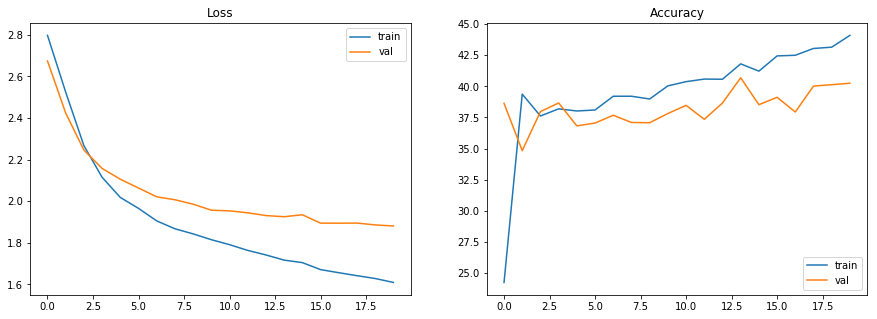

In [46]:
# Plot performance
plot_performance(train_state=trainer.train_state, 
                 save_dir=config["save_dir"], show_plot=True)

In [47]:
# Test performance
trainer.run_test_loop()

==> 💯 Test performance:
Test loss: 1.94
Test Accuracy: 41.4%


In [48]:
# Save all results
save_train_state(train_state=trainer.train_state, save_dir=config["save_dir"])

==> ✅ Training complete!


# Inference

Components to see how our trained model fares against unseen surnames.

### Components

In [0]:
class Inference(object):
    def __init__(self, model, vectorizer, device="cpu"):
        self.model = model.to(device)
        self.vectorizer = vectorizer
        self.device = device
  
    def predict_nationality(self, dataset):
        # Batch generator
        batch_generator = dataset.generate_batches(
            batch_size=len(dataset), shuffle=False, device=self.device)
        self.model.eval()
        
        # Predict
        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred =  self.model(batch_dict['surname'], apply_softmax=True)

            # Top k nationalities
            y_prob, indices = torch.topk(y_pred, k=len(self.vectorizer.nationality_vocab))
            probabilities = y_prob.detach().to('cpu').numpy()[0]
            indices = indices.detach().to('cpu').numpy()[0]

            results = []
            for probability, index in zip(probabilities, indices):
                nationality = self.vectorizer.nationality_vocab.lookup_index(index)
                results.append({'nationality': nationality, 'probability': probability})

        return results

### Operations

In [0]:
# Load vectorizer
with open(config["vectorizer_file"]) as fp:
    vectorizer = SurnameVectorizer.from_serializable(json.load(fp))

In [51]:
# Load the model
model = initialize_model(config=config, vectorizer=vectorizer)
model.load_state_dict(torch.load(config["model_file"]))


==> 🚀 Initializing model:
<bound method Module.named_modules of SurnameModel(
  (fc1): Linear(in_features=28, out_features=300, bias=True)
  (dropout): Dropout(p=0.1)
  (fc2): Linear(in_features=300, out_features=18, bias=True)
)>


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
# Initialize
inference = Inference(model=model, vectorizer=vectorizer, device=config["device"])

In [53]:
# Inference
surname = input("Enter a surname to classify: ")
nationality = list(vectorizer.nationality_vocab.token_to_idx.keys())[0] # random filler nationality
infer_df = pd.DataFrame([[surname, nationality, "infer"]], columns=['surname', 'nationality', 'split'])
infer_df.surname = infer_df.surname.apply(preprocess_text)
infer_dataset = SurnameDataset(df=infer_df, vectorizer=vectorizer, infer=True)
results = inference.predict_nationality(dataset=infer_dataset)
results

Enter a surname to classify: tt


[{'nationality': 'Vietnamese', 'probability': 0.54834723},
 {'nationality': 'Chinese', 'probability': 0.17494124},
 {'nationality': 'Korean', 'probability': 0.09927005},
 {'nationality': 'English', 'probability': 0.024913054},
 {'nationality': 'Scottish', 'probability': 0.024463426},
 {'nationality': 'German', 'probability': 0.022026833},
 {'nationality': 'Arabic', 'probability': 0.02151887},
 {'nationality': 'Japanese', 'probability': 0.014538854},
 {'nationality': 'Spanish', 'probability': 0.013843147},
 {'nationality': 'French', 'probability': 0.011528387},
 {'nationality': 'Italian', 'probability': 0.010669775},
 {'nationality': 'Dutch', 'probability': 0.009651789},
 {'nationality': 'Portuguese', 'probability': 0.008321338},
 {'nationality': 'Czech', 'probability': 0.007971795},
 {'nationality': 'Irish', 'probability': 0.004123347},
 {'nationality': 'Polish', 'probability': 0.002124458},
 {'nationality': 'Russian', 'probability': 0.0011469562},
 {'nationality': 'Greek', 'probabilit

# TODO

- tqdm notebook